### Read the data from the input Excel file

In [113]:
import pandas as pd
inputFileName = "DataBlender.xlsx"
paramDF = pd.read_excel(inputFileName, "Param", skiprows=2)
rawMaterialsDF = pd.read_excel(inputFileName, "RawMaterials", skiprows=2)
finishedGoodsDF = pd.read_excel(inputFileName, "FinishedGoods", skiprows=2)

### Set the data into list and dict, easier to manipulate

In [114]:
#Raw materials characteristics
rawMaterials_items = list(rawMaterialsDF['Raw materials'])
costRM = list(rawMaterialsDF['Cost'])
capacityRM = list(rawMaterialsDF['Capacity'])
volumeMinRM = list(rawMaterialsDF['VolumeMin'])
supplierRM = list(rawMaterialsDF['Supplier'])
suppliers_items = list(set(supplierRM))  #supplier list, obtained by removing duplicates

componentsRM = dict()
componentsRM['Component1'] = list(rawMaterialsDF['Component1'])
componentsRM['Component2'] = list(rawMaterialsDF['Component2'])
componentsRM['Component3'] = list(rawMaterialsDF['Component3'])

#Finished goods characteristics
finishedGoods_items = list(finishedGoodsDF['Finished goods'])
demandFG = list(finishedGoodsDF['Demand'])

componentsMinFG = dict()
componentsMinFG['Component1'] = list(finishedGoodsDF['MinComponent1'])
componentsMinFG['Component2'] = list(finishedGoodsDF['MinComponent2'])
componentsMinFG['Component3'] = list(finishedGoodsDF['MinComponent3'])

componentsMaxFG = dict()
componentsMaxFG['Component1'] = list(finishedGoodsDF['MaxComponent1'])
componentsMaxFG['Component2'] = list(finishedGoodsDF['MaxComponent2'])
componentsMaxFG['Component3'] = list(finishedGoodsDF['MaxComponent3'])


### Create your linear program

In [115]:
from pulp import *
prob = LpProblem("BlenderProblem",LpMinimize)

### Add variables

In [116]:
RecipeVar = LpVariable.dicts("Recipe", ((i, j) for i in rawMaterials_items for j in finishedGoods_items), 
                             lowBound=0, cat='Continuous')
RM_VolumeVar = LpVariable.dicts("RMvolume", (i for i in rawMaterials_items), lowBound=0, cat='Continuous')
FG_VolumeVar = LpVariable.dicts("FGvolume", (j for j in finishedGoods_items), lowBound=0, cat='Continuous')

### Add objectives

In [117]:
prob += lpSum([costRM[iRM] * RM_VolumeVar[vRM] for iRM, vRM in enumerate(rawMaterials_items)])

### Add constraints

In [118]:
#Define RM_VolumeVar
for iRM in rawMaterials_items : 
    prob += lpSum([RecipeVar[iRM,iFG] for iFG in finishedGoods_items]) == RM_VolumeVar[iRM], "defVolumeRM[%s]"%(iRM)
    
#Define FG_VolumeVar
for iFG in finishedGoods_items : 
    prob += lpSum([RecipeVar[iRM,iFG] for iRM in rawMaterials_items]) == FG_VolumeVar[iFG], "defVolumeFG[%s]"%(iFG)
    
#Capacity constraint
for iRM, vRM in enumerate(rawMaterials_items) : 
    prob += RM_VolumeVar[vRM] <= capacityRM[iRM], "capacity[%s]"%(iRM)

#Demand constraint
for iFG, vFG in enumerate(finishedGoods_items) : 
    prob += FG_VolumeVar[vFG] >= demandFG[iFG], "demandFG[%s]"%(iFG)
    
#Min & max components in the finished goods
for iComponent in ['Component1', 'Component2', 'Component3']:
    for iFG, vFG in enumerate(finishedGoods_items) : 
        #print(componentsMinFG[iComponent][iFG])
        prob += lpSum([componentsRM[iComponent][iRM] * RecipeVar[vRM,vFG] for iRM, vRM in enumerate(rawMaterials_items)]) >= FG_VolumeVar[vFG] * componentsMinFG[iComponent][iFG]
        prob += lpSum([componentsRM[iComponent][iRM] * RecipeVar[vRM,vFG] for iRM, vRM in enumerate(rawMaterials_items)]) <= FG_VolumeVar[vFG] * componentsMaxFG[iComponent][iFG]

### Solve the problem and store the variable into a dictionnary

In [119]:
#prob.writeLP("blenderProblem.lp", writeSOS=1, mip=1)
prob.solve()
print("Status:", LpStatus[prob.status])
print ("Objective = ", value(prob.objective))
varsDict = {}
for v in prob.variables():
    varsDict[v.name] = v.varValue
    if "RMvolume" in v.name:
        print(v.name, "=", v.varValue)


Status: Optimal
Objective =  132657.67138369998
RMvolume_I1 = 760.71831
RMvolume_I10 = 219.20615
RMvolume_I2 = 121.07554
RMvolume_I3 = 600.0
RMvolume_I4 = 500.0
RMvolume_I5 = 500.0
RMvolume_I6 = 800.0
RMvolume_I7 = 1000.0
RMvolume_I8 = 1000.0
RMvolume_I9 = 0.0


import matplotlib.pyplot as plt
import numpy as np

myArray = np.zeros((len(rawMaterials_items), len(finishedGoods_items)), dtype=np.float)
for i in rawMaterials_items:
    for j in finishedGoods_items :
        myArray[i][j] = prob.variables("Recipe_('I1',_'O1')").varValue
plt.imshow(myArray, cmap='hot', interpolation='nearest')
plt.show()

In [120]:
for name, c in list(prob.constraints.items()): print(name, ":", c.pi, "\t\t", c.slack)

defVolumeRM_I1_ : -28.55 		 1.563194e-13
defVolumeRM_I2_ : -27.33 		 8.8817842e-15
defVolumeRM_I3_ : -27.617059 		 -0.0
defVolumeRM_I4_ : -25.105294 		 -1.1368684e-13
defVolumeRM_I5_ : -24.028824 		 -5.6843419e-14
defVolumeRM_I6_ : -24.028824 		 -1.7053026e-13
defVolumeRM_I7_ : -31.389278 		 1.1368684e-13
defVolumeRM_I8_ : -26.038235 		 -1.1368684e-13
defVolumeRM_I9_ : -32.9 		 -0.0
defVolumeRM_I10_ : -27.5 		 2.8421709e-14
defVolumeFG_O1_ : 23.024118 		 -1.2434498e-13
defVolumeFG_O2_ : 23.024118 		 -1.9895197e-13
defVolumeFG_O3_ : 23.024118 		 -1.1368684e-13
defVolumeFG_O4_ : 25.342453 		 -2.2737368e-13
capacity_0_ : 0.0 		 239.28169000000003
capacity_1_ : 0.0 		 878.92446
capacity_2_ : -4.8070588 		 -0.0
capacity_3_ : -15.105294 		 -0.0
capacity_4_ : -0.068823529 		 -0.0
capacity_5_ : -3.9088235 		 -0.0
capacity_6_ : -1.8492785 		 -0.0
capacity_7_ : -0.73823529 		 -0.0
capacity_8_ : 0.0 		 1000.0
capacity_9_ : 0.0 		 780.79385
demandFG_0_ : 27.114706 		 -0.0
demandFG_1_ : 25.822941 	

<ipython-input-121-815a6481d03e>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  myArray = np.zeros((len(rawMaterials_items), len(finishedGoods_items)), dtype=np.float)


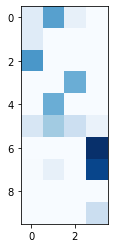

[[ 118.96148    560.24096     81.515869     0.       ]
 [ 117.49945      0.           3.576092     0.       ]
 [ 600.           0.           0.           0.       ]
 [   0.           0.         500.           0.       ]
 [   0.         500.           0.           0.       ]
 [ 159.41578    361.01549    214.90804     64.660691 ]
 [   0.           0.           0.        1000.       ]
 [   5.1232918   78.743546     0.         916.13316  ]
 [   0.           0.           0.           0.       ]
 [   0.           0.           0.         219.20615  ]]


In [121]:
import matplotlib.pyplot as plt 
import numpy as np

myArray = np.zeros((len(rawMaterials_items), len(finishedGoods_items)), dtype=np.float)


for iRM, vRM in enumerate(rawMaterials_items):
    for iFG, vFG in enumerate(finishedGoods_items): 
        myArray[iRM][iFG] = varsDict["Recipe_(\'%s\',_\'%s\')" %(vRM, vFG)]
plt.imshow(myArray, cmap='Blues', interpolation='nearest')
plt.show()
print(myArray)

In [122]:
for name, c in list(prob.constraints.items()): print(name, ":", c.pi, "\t\t", c.slack)

defVolumeRM_I1_ : -28.55 		 1.563194e-13
defVolumeRM_I2_ : -27.33 		 8.8817842e-15
defVolumeRM_I3_ : -27.617059 		 -0.0
defVolumeRM_I4_ : -25.105294 		 -1.1368684e-13
defVolumeRM_I5_ : -24.028824 		 -5.6843419e-14
defVolumeRM_I6_ : -24.028824 		 -1.7053026e-13
defVolumeRM_I7_ : -31.389278 		 1.1368684e-13
defVolumeRM_I8_ : -26.038235 		 -1.1368684e-13
defVolumeRM_I9_ : -32.9 		 -0.0
defVolumeRM_I10_ : -27.5 		 2.8421709e-14
defVolumeFG_O1_ : 23.024118 		 -1.2434498e-13
defVolumeFG_O2_ : 23.024118 		 -1.9895197e-13
defVolumeFG_O3_ : 23.024118 		 -1.1368684e-13
defVolumeFG_O4_ : 25.342453 		 -2.2737368e-13
capacity_0_ : 0.0 		 239.28169000000003
capacity_1_ : 0.0 		 878.92446
capacity_2_ : -4.8070588 		 -0.0
capacity_3_ : -15.105294 		 -0.0
capacity_4_ : -0.068823529 		 -0.0
capacity_5_ : -3.9088235 		 -0.0
capacity_6_ : -1.8492785 		 -0.0
capacity_7_ : -0.73823529 		 -0.0
capacity_8_ : 0.0 		 1000.0
capacity_9_ : 0.0 		 780.79385
demandFG_0_ : 27.114706 		 -0.0
demandFG_1_ : 25.822941 	